# Source Code Notebook - InceptionV3


## Google Colab Configs


In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Image Conversion and Validation


### Checking of the validity of Images in the dataset


In [123]:
import cv2
import os
from pathlib import Path
# DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

# For Colab:
DATA_DIR = "/content/drive/MyDrive/dataset/AI Art vs Real Art"
import imghdr
IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

## Data Preprocessing


### Import Tensorflow and Keras and check on available GPU


In [124]:
import sys
import tensorflow as tf
import keras
import platform
import numpy as np
print(f"Python Platform: {platform.version()}")
print(f"Python Version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Tensorflow version: 2.15.0
Keras version: 2.15.0

GPU is available


### Set constants for Images


In [125]:
BATCH_SIZE = 64
HEIGHT = 256
WIDTH = 256
IMAGE_SIZE = (HEIGHT, WIDTH)

### Use Keras' Preprocessing modules to split data


In [126]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2,
    subset="training",
)

val_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2, # use 20% as validation
    subset="validation",
)
# The target labels
class_names = train_dataset.class_names
print(class_names)

Found 912 files belonging to 2 classes.
Using 730 files for training.
Found 912 files belonging to 2 classes.
Using 182 files for validation.
['AI Art', 'Real']


### Display Sample Images


<ipython-input-127-96b3d0b641c5>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[i].numpy())])


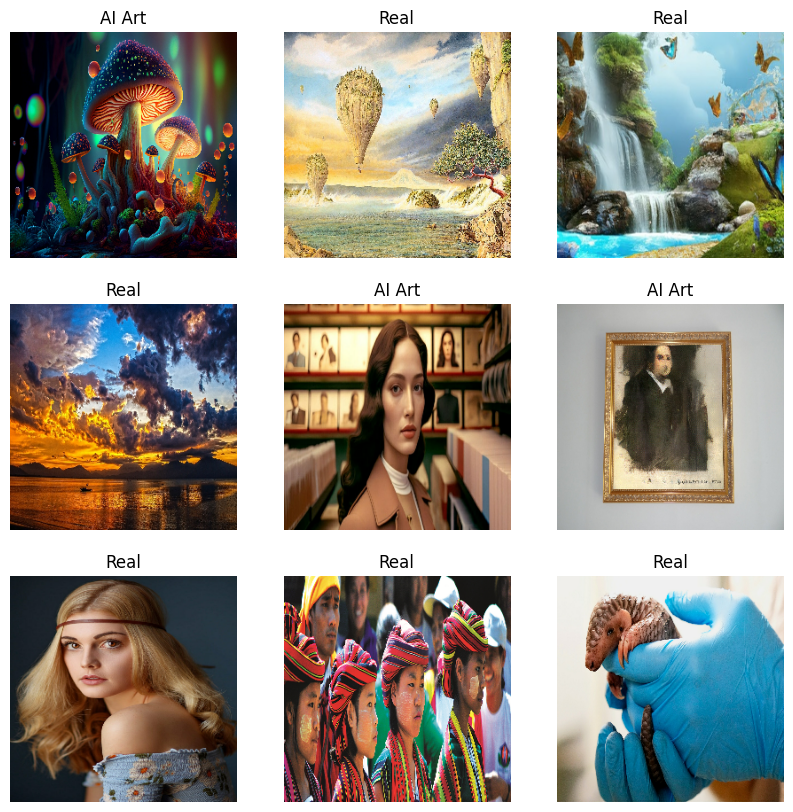

In [127]:
import matplotlib.pyplot as plt

def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")
display_binary_images(train_dataset, class_names)

### Rescale


### Data Augmentation


In [128]:
augmentation_layers = [
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

### Prefetch Data for Optimization


In [129]:
from tensorflow import data as tf_data

train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE).cache()
val_dataset = val_dataset.prefetch(tf_data.AUTOTUNE).cache()


### Display Data Augmentation


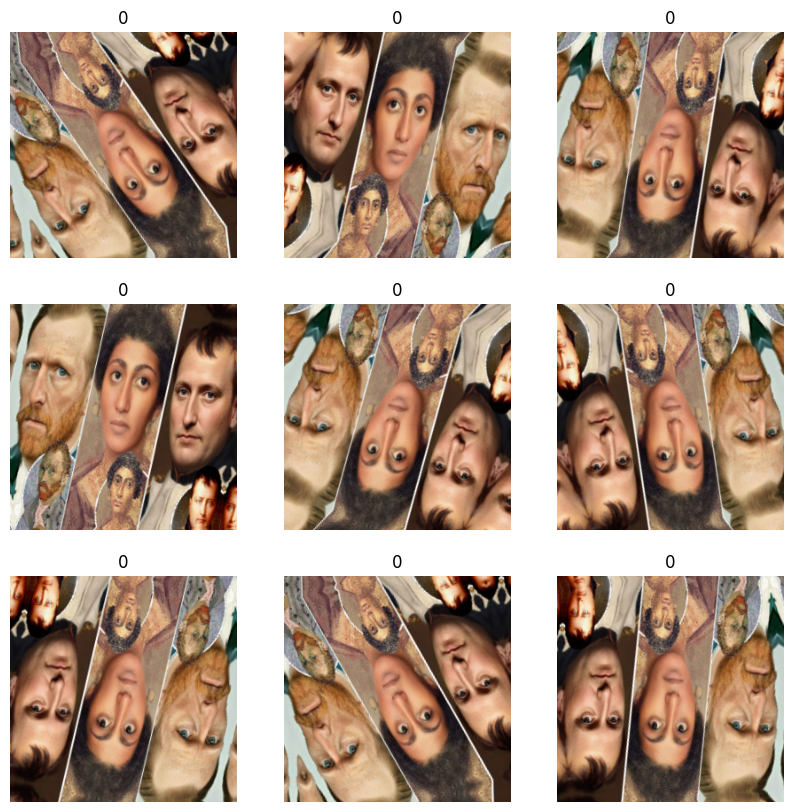

In [130]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")


## Importing InceptionV3 and Base Training


### Import InceptionV3 as our base model


In [131]:
base_model = keras.applications.InceptionV3(
    include_top=False, # Do not include the final layer, which classifies images
    weights="imagenet",
    pooling='avg',
)

### Make base model non-trainable


In [132]:
for layer in base_model.layers:
    layer.trainable = False

## Fine-Tuning the model


### Util Methods


In [133]:
# Dynamic Learning Rate
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.1
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1 + epoch)
        / epochs_drop))
    return lr

In [134]:
stop = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    start_from_epoch=5,
    verbose=1)

callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(lr_schedule),
]

### Create new Model on Top


In [135]:
from keras import layers
# Starting layers
inputs = keras.Input(shape=(HEIGHT, WIDTH, 3))
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(inputs, training=False) # run in inference mode

x = layers.Flatten()(x)
x = layers.Dense(2056, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)  # Add dropout for regularization
x = layers.Dense(512, activation='relu')(x)  # Add another dense layer
x = layers.Dropout(0.2)(x)  # Add dropout for regularization
x = layers.Dense(256, activation='relu')(x)  # Add another dense layer
x = layers.Dropout(0.2)(x)  # Add dropout for regularization
outputs = layers.Dense(1, activation='sigmoid')(x)

### Compile the Model


In [136]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary(show_trainable=True)

stop = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    start_from_epoch=5,
    verbose=1)

callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(lr_schedule),
]

Model: "model_5"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         Y          
                                                                            
 inception_v3 (Functional)   (None, 2048)              2180278   Y          
                                                       4                    
                                                                            
 flatten_3 (Flatten)         (None, 2048)              0         Y          
                                                                            
 dense_10 (Dense)            (None, 2056)              4212744   Y          
                                                                            
 dropout_5 (Dropout)         (None, 2056)              0         Y          
                                                           

### Train the Top Layer


In [137]:
EPOCHS = 50

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics= [keras.metrics.BinaryAccuracy()],
)

print("Fitting the top layer of the model")

model.fit(train_dataset,
          epochs=EPOCHS,
          validation_data=val_dataset,
          callbacks=callbacks,
)

Fitting the top layer of the model
Epoch 1/50
12/12 [==============================] - 29s 1s/step - loss: 47.0062 - binary_accuracy: 0.4699 - val_loss: 1.4517 - val_binary_accuracy: 0.5110 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 3s 217ms/step - loss: 1.1412 - binary_accuracy: 0.4986 - val_loss: 0.6773 - val_binary_accuracy: 0.6319 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 2s 204ms/step - loss: 0.9690 - binary_accuracy: 0.5603 - val_loss: 0.6962 - val_binary_accuracy: 0.5385 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 3s 219ms/step - loss: 1.0833 - binary_accuracy: 0.5027 - val_loss: 0.8272 - val_binary_accuracy: 0.5110 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 3s 223ms/step - loss: 0.8241 - binary_accuracy: 0.5370 - val_loss: 0.9351 - val_binary_accuracy: 0.5110 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 4s 330ms/step - loss: 0.9192 - binary_accuracy: 0.5082 - val_loss: 0.

## Fine Tuning the Model


### Util Methods


In [138]:
# Dynamic Learning Rate
def fine_tuned_lr_schedule(epoch):
    initial_lr = 0.00001
    drop = 0.1
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1 + epoch)
        / epochs_drop))
    return lr

In [139]:
stop = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    start_from_epoch=5,
    verbose=1)

callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(fine_tuned_lr_schedule),
]

### Unfreeze Layers


In [140]:
N = 15  # Number of layers to unfreeze from the end
for layer in base_model.layers[-N:]:
    layer.trainable = True

In [141]:
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics= [keras.metrics.BinaryAccuracy()],
)

Model: "model_5"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         Y          
                                                                            
 inception_v3 (Functional)   (None, 2048)              2180278   Y          
                                                       4                    
                                                                            
 flatten_3 (Flatten)         (None, 2048)              0         Y          
                                                                            
 dense_10 (Dense)            (None, 2056)              4212744   Y          
                                                                            
 dropout_5 (Dropout)         (None, 2056)              0         Y          
                                                           

In [142]:
print("Fitting the end-end model")
fine_tuned_model = model.fit(train_dataset,
          epochs=EPOCHS,
          validation_data=val_dataset,
          callbacks=callbacks,
)

Fitting the end-end model
Epoch 1/50
12/12 [==============================] - 9s 318ms/step - loss: 0.6114 - binary_accuracy: 0.6822 - val_loss: 0.6381 - val_binary_accuracy: 0.6813 - lr: 1.0000e-05
Epoch 2/50
12/12 [==============================] - 2s 203ms/step - loss: 0.6075 - binary_accuracy: 0.6548 - val_loss: 0.6399 - val_binary_accuracy: 0.6758 - lr: 1.0000e-05
Epoch 3/50
12/12 [==============================] - 2s 207ms/step - loss: 0.5853 - binary_accuracy: 0.6932 - val_loss: 0.6392 - val_binary_accuracy: 0.6813 - lr: 1.0000e-05
Epoch 4/50
12/12 [==============================] - 2s 206ms/step - loss: 0.5902 - binary_accuracy: 0.6932 - val_loss: 0.6405 - val_binary_accuracy: 0.6813 - lr: 1.0000e-05
Epoch 5/50
12/12 [==============================] - 2s 205ms/step - loss: 0.6077 - binary_accuracy: 0.6685 - val_loss: 0.6423 - val_binary_accuracy: 0.6593 - lr: 1.0000e-05
Epoch 6/50
12/12 [==============================] - 3s 234ms/step - loss: 0.5816 - binary_accuracy: 0.6795 - 

## Evaluation of the Model


### Predicting a Specific Image


1/1 [==============================] - 1s 1s/step
Predictions: [0.6550898]
The predicted class for the image /content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg is: Real Art


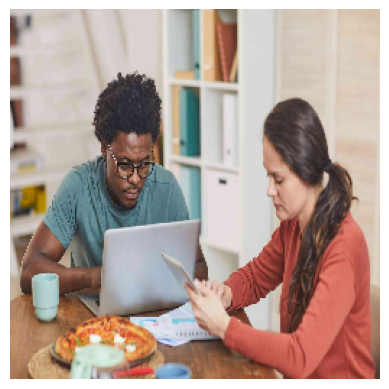

In [143]:
# img_path = "dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg"
img_path = "/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg"

img = keras.preprocessing.image.load_img(img_path,
                                            target_size=(HEIGHT, WIDTH))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

print(f"Predictions: {predictions}")

# Interpret the prediction (assuming binary classification with 0 for Real Art and 1 for AI Art)
# Ensure predictions is in the correct format
if len(predictions.shape) == 1:
    predicted_class = 'Real Art' if predictions[0] > 0.5 else 'AI Art'
else:
    predicted_class = 'Real Art' if predictions[0][0] > 0.5 else 'AI Art'

# Create a string with the predicted label
result_string = f'The predicted class for the image {img_path} is: {predicted_class}'
print(result_string)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Predicting a Random Image


/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art/AiArtData
1/1 [==============================] - 0s 29ms/step
Predictions: [0.35494038]
The predicted class for the image cute-furry-animal-ai-generated_970779-15.jpeg is: AI Art


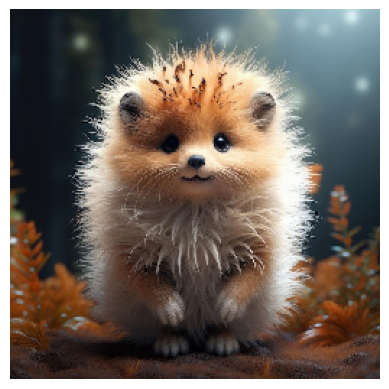

In [144]:
import os
import random
folder_number = random.randint(1, 2)  # Generate a random number between 1-3
# if folder_number == 1:
#     dataset_dir = "dataset/AI Art vs Real Art/AI Art/AiArtData"
# else:
#     dataset_dir = "dataset/AI Art vs Real Art/Real/RealArt"

if folder_number == 1:
    dataset_dir = "/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art/AiArtData"
else:
    dataset_dir = "/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt"
print(dataset_dir)
file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)
image_path = os.path.join(dataset_dir, random_file)

img = tf.keras.preprocessing.image.load_img(image_path,
                                            target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

print(f"Predictions: {predictions}")

# Interpret the prediction (assuming binary classification with 0 for Real Art and 1 for AI Art)
# Ensure predictions is in the correct format
if len(predictions.shape) == 1:
    predicted_class = 'Real Art' if predictions[0] > 0.5 else 'AI Art'
else:
    predicted_class = 'Real Art' if predictions[0][0] > 0.5 else 'AI Art'

# Create a string with the predicted label
result_string = f'The predicted class for the image {random_file} is: {predicted_class}'
print(result_string)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Visualization in terms of Epochs


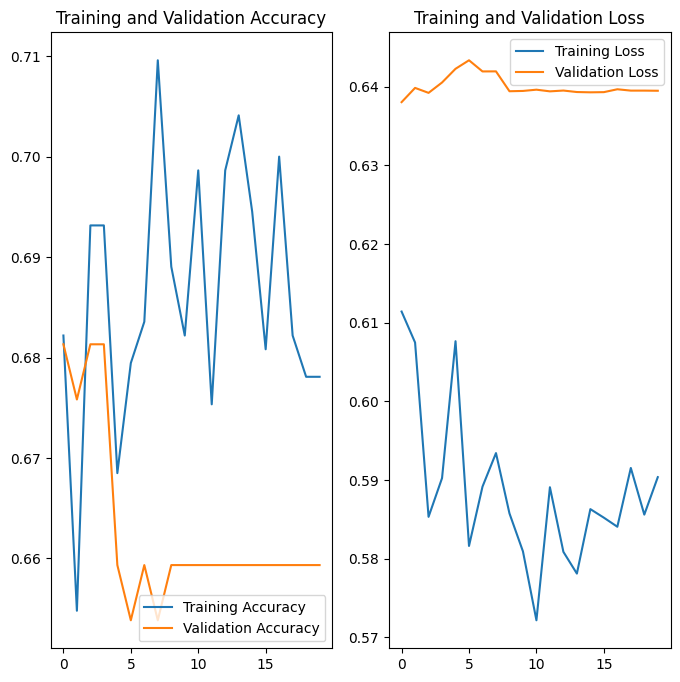

In [145]:
acc = fine_tuned_model.history['binary_accuracy']
val_acc = fine_tuned_model.history['val_binary_accuracy']

loss = fine_tuned_model.history['loss']
val_loss = fine_tuned_model.history['val_loss']
if stop.stopped_epoch != 0:
    epochs_range = range(stop.stopped_epoch+1)
else:
    epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()